<a href="https://colab.research.google.com/github/vk18mishra/Multilingual-Landscaping-in-Dortmund-Nordstadt/blob/main/RMEL_Project_Landscaping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multilingual Landscaping for RMEL**

## **Installing unavailable packages**

In [ ]:
!pip install tqdm
!pip install easyocr opencv-python
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

## **Importing required libraries**

In [2]:
import os
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from easyocr import Reader
import argparse
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import math
import pandas as pd
import numpy as np

## **Getting Image Names from the directory**

In [25]:
onlyfiles = [f for f in listdir("/content/drive/MyDrive/RMEL PROJECT") if isfile(join("/content/drive/MyDrive/RMEL PROJECT", f))]
print("Total Number of Images: ",len(onlyfiles))

Total Number of Images:  89


## **Resizing the Images to 1280x720 and compressing them**

In [26]:
for img_name in tqdm(onlyfiles):
  image_nm = "/content/drive/MyDrive/RMEL PROJECT/"+img_name
  foo = Image.open(image_nm)
  x, y = foo.size
  #print("Original File Size: ",os.stat("/content/drive/MyDrive/RMEL PROJECT/IMG_20220128_173721.jpg").st_size)
  #print(x,y)
  x2, y2 = 1280,720 #math.floor(x-2500), math.floor(y-2000)
  #print(x2,y2)
  foo = foo.resize((x2,y2),Image.ANTIALIAS)
  image_dest = "/content/drive/MyDrive/RMEL PROJECT/Compressed/"+img_name
  foo.save(image_dest,quality=40)
  #print("Compressed File Size: ",os.stat("/content/drive/MyDrive/RMEL PROJECT/Compressed/IMG_20220128_173721.jpg").st_size)

100%|██████████| 89/89 [01:21<00:00,  1.09it/s]


## **Performing OCR on the Compressed Images**

In [27]:
#langs = "de,ar,tr,en"
langs1 = ["en","tr","de"]#langs.split(",")
print("[INFO] Using the following languages: {}".format(langs1))
print("[INFO] Performing OCR on the input Images...")
reader1 = Reader(langs1, gpu=True)
results1 = []
for img_name in tqdm(onlyfiles):
  image_nm = "/content/drive/MyDrive/RMEL PROJECT/Compressed/"+img_name
  #image = "/content/drive/MyDrive/RMEL PROJECT/Compressed/IMG_20220128_173721.jpg"

  #langs2 = ["ar"]
  #langs = ["en","tr","de","ar"]
  image = cv2.imread(image_nm)
  #reader2 = Reader(langs2, gpu=False)
  results_temp = reader1.readtext(image)
  results1.append(results_temp)
  #results2 = reader2.readtext(image)

[INFO] Using the following languages: ['en', 'tr', 'de']
[INFO] Performing OCR on the input Images...


100%|██████████| 89/89 [00:40<00:00,  2.20it/s]


## **Removing Noise and Creating the Final Dataframe - Image to Text**

### **Removing any text that contains digits, special characters or Redmi's watermark**

In [38]:
lowecase_text = []
main_list_text = []
special_characters = "\"!@#$%^&*()-+?_=,<>\""
for img_fn in tqdm(results1):
  list_text = []
  for (bbox, text, prob) in img_fn:
    text_t = text.lower()
    digit_bool = any(i.isdigit() for i in text_t)
    if digit_bool == True:
      continue
    if any(c in special_characters for c in text_t):
      continue
    if(text_t in ["al quad camera", "redmi", "note",
                "pro", "redm", "al quad gamera", "ai", "quad", "alquad camera" 
                "camera", "quadcamera", "al quadcamera"]):
      continue  
    list_text.append(text_t)
  lowecase_text.append(list_text)
main_list_text = lowecase_text

100%|██████████| 89/89 [00:00<00:00, 17191.35it/s]


In [44]:
df1 = {
  'Image Name':onlyfiles,
  'Text':main_list_text}

df1 = pd.DataFrame(df1,columns=['Image Name','Text'])

df1.head()

Image Name                                               Text
0  IMG_20220128_174011.jpg                                                 []
1  IMG_20220128_173838.jpg  [döner, grill, salate, iaglicm hausgemachter, ...
2  IMG_20220128_173721.jpg           [s, caglar, damen, herren, salom, p, en]
3  IMG_20220128_173405.jpg  [ourfaci, rusumcu, al quadiiiamera, ourfali, a...
4  IMG_20220128_173346.jpg             [konyelıfş, fralslerladen, pelhe, fut]

## **Saving the results in a CSV**

In [48]:
df1.to_csv('ImagetoText_updated.csv')

## **Working Example**

In [45]:
img_name = onlyfiles[24]
image_nm = "/content/drive/MyDrive/RMEL PROJECT/Compressed/"+img_name
image = cv2.imread(image_nm)
results_temp = reader1.readtext(image)

[INFO] 0.614989: Anmopische Habesha Restaurant
[INFO] 0.976899: Eritreishe
[INFO] 0.107124: 8"
[INFO] 0.028960: Ankan
[INFO] 0.031120: P"' ' -
[INFO] 0.115112: S
[INFO] 0.829836: Tel-015214827460
[INFO] 0.379743: AdresseMunsterstrane
[INFO] 0.996163: 01729513478
[INFO] 0.998474: 44145 Dortmund
[INFO] 0.946818: 'BENA
[INFO] 0.003041: GiA6ESGG
[INFO] 0.470102: Incra
[INFO] 0.295656: ReDMINnOTE 8 PRO
[INFO] 0.748336: AlQUAD CAMERA
[INFO] 0.777724: ud


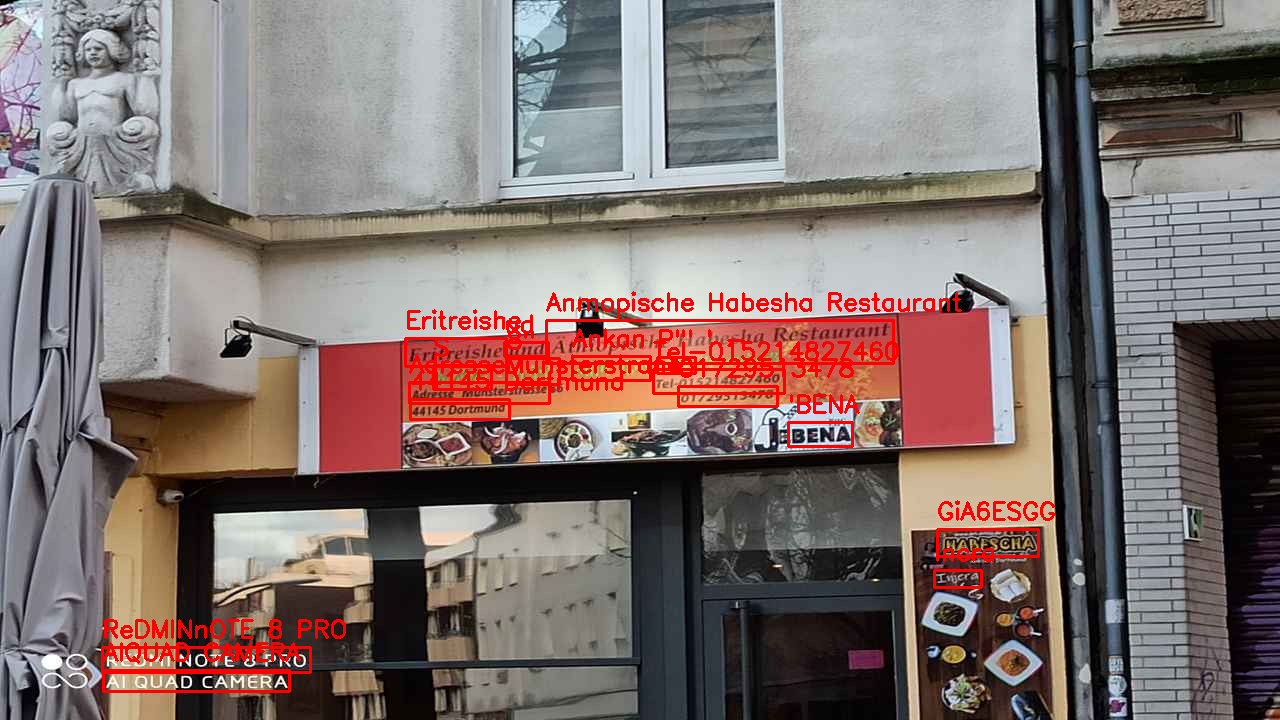

In [46]:
for (bbox, text, prob) in results_temp:
  print("[INFO] {:4f}: {}".format(prob,text))
  (top_left, top_right, bottom_right, bottom_left) = bbox

  tl = (int(top_left[0]), int(top_left[1]))
  tr = (int(top_right[0]), int(top_right[1]))
  br = (int(bottom_right[0]), int(bottom_right[1]))
  bl = (int(bottom_left[0]), int(bottom_left[1]))

  cv2.rectangle(image, tl, br, (0, 0, 255), 2)
  cv2.putText(image, text, (tl[0], tl[1] - 10),
              cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

# image_nm = "/content/drive/MyDrive/RMEL PROJECT/Compressed/"+onlyfiles[88]
# image = cv2.imread(image_nm)
cv2_imshow(image)
#cv2.waitKey(0)

In [47]:
list_text = []
special_characters = "\"!@#$%^&*()-+?_=,<>\""
for (bbox, text, prob) in results_temp:
    text_t = text.lower()
    digit_bool = any(i.isdigit() for i in text_t)
    if digit_bool == True:
      continue
    if any(c in special_characters for c in text_t):
      continue
    if(text_t in ["al quad camera", "redmi", "note",
                "pro", "redm", "al quad gamera", "ai", "quad", "alquad camera" 
                "camera", "quadcamera", "al quadcamera"]):
      continue  
    list_text.append(text_t)

df_temp = {
  'Image Name':onlyfiles[24],
  'Text':list_text}

df_temp = pd.DataFrame(df_temp,columns=['Image Name','Text'])

df_temp

Image Name                           Text
0  IMG_20220128_162302.jpg  anmopische habesha restaurant
1  IMG_20220128_162302.jpg                     eritreishe
2  IMG_20220128_162302.jpg                          ankan
3  IMG_20220128_162302.jpg                              s
4  IMG_20220128_162302.jpg           adressemunsterstrane
5  IMG_20220128_162302.jpg                          'bena
6  IMG_20220128_162302.jpg                          incra
7  IMG_20220128_162302.jpg                  alquad camera
8  IMG_20220128_162302.jpg                             ud

## **Performing Analysis on the data obtained**

In [ ]:
!pip install langdetect

In [62]:
from langdetect import detect
import matplotlib.pyplot as plt

### **Finding the language of each text detected**

In [65]:
langs = []
dict_lang = dict()
for img_wd in tqdm(main_list_text):
  if not img_wd:
    continue
  for word in img_wd:
    # b = TextBlob(word)
    # print(word)
    try:
      lang_wd = detect(word)
    except:
        lang_wd = "error"
        print("This word throws error:", word)
    #langs.append(lang_wd)
    if lang_wd not in dict_lang:
      dict_lang[lang_wd] = 1
    else:
      dict_lang[lang_wd] = dict_lang[lang_wd] + 1
# langs_set = set(langs)
# print(langs_set)

 16%|█▌        | 14/89 [00:00<00:03, 21.57it/s]

This word throws error: 


 40%|████      | 36/89 [00:03<00:06,  8.13it/s]

This word throws error: '


 55%|█████▌    | 49/89 [00:04<00:03, 11.06it/s]

This word throws error: :


 90%|████████▉ | 80/89 [00:07<00:00, 10.95it/s]

This word throws error: 


100%|██████████| 89/89 [00:08<00:00, 10.10it/s]

This word throws error: ~
This word throws error: 


### **Sorting according to the frequency of the language**

In [104]:
dict_lang_t = sorted(dict_lang.items(), key=lambda x: x[1], reverse=True)
lang_list_sort = []
freq_sort = []
for lang in dict_lang_t:
    lang_list_sort_t = lang[0]
    freq_sort_t = lang[1]
    lang_list_sort.append(lang_list_sort_t)
    freq_sort.append(freq_sort_t)

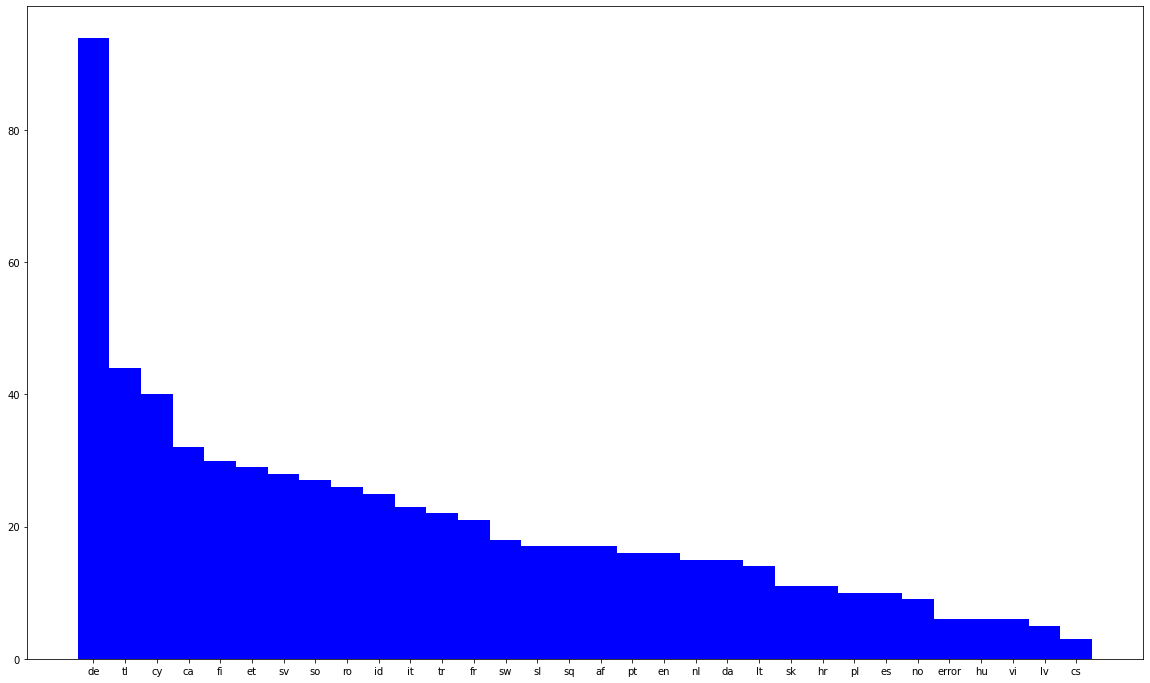

In [105]:
width = 1.0
plt.figure(figsize=(20,12))
plt.bar(lang_list_sort, freq_sort, width, color='b')
plt.show()

### **Restricting ourselves to just the languages we performed OCR upon**

In [106]:
lang_list_sort = []
freq_sort = []
for lang in dict_lang_t:
    lang_list_sort_t = lang[0]
    if lang_list_sort_t not in ['de', 'tr', 'en', 'error']:
      continue
    freq_sort_t = lang[1]
    lang_list_sort.append(lang_list_sort_t)
    freq_sort.append(freq_sort_t)

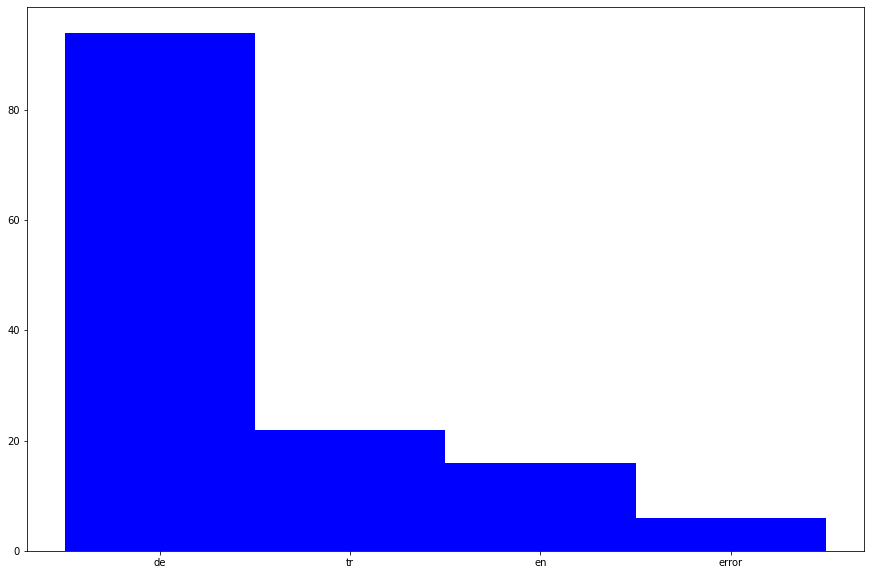

In [108]:
width = 1.0
plt.figure(figsize=(15,10))
plt.bar(lang_list_sort, freq_sort, width, color='b')
plt.show()